In [1]:
import calour as ca
import calour_utils as cu

failed to load logging config file


In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import shutil
import matplotlib.colors
import skbio as skbio
import glob

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [3]:
ca.set_log_level('INFO')

In [4]:
%matplotlib inline

In [5]:
pwd

'/Users/amnon/Projects/sheba/metaanalysis/scripts'

In [6]:
testzz = ca.read_amplicon('../studies/10/all.biom','../studies/10/up.map.csv',min_reads=1000,normalize=10000, sparse=False)

2021-04-06 00:22:13 INFO loaded 174 samples, 3295 features
2021-04-06 00:22:13 WARNING These have metadata but do not have data - dropped (2): {'SRR1687461', 'SRR1689253'}
2021-04-06 00:22:13 WARNING Do you forget to normalize your data? It is required before running this function
2021-04-06 00:22:13 INFO After filtering, 174 remain.


# Load the nonspecific up/down feature list

In [7]:
nsd = pd.read_csv('../ratios/nonspecific/nonspecific-down_feature.txt',sep='\t',index_col=0)
nsd['dir'] = 'down'
nsu = pd.read_csv('../ratios/nonspecific/nonspecific-up_feature.txt',sep='\t',index_col=0)
nsu['dir'] = 'up'
ns = nsd.merge(nsu,how='outer')
ns['dir'].value_counts()

down    97
up      31
Name: dir, dtype: int64

# Calculate dysbiosis index for a study directory

In [11]:
def dbi_binary(exp, nsf, thresh=0, outfile=None):
    '''Binary index:
    Parameters
    ----------
    exp: calour.Experiment
        Witht the samples to calculate the index
    nsf: pd.DataFrame
        with feature sequence as index, dir='up'/'down'
    
    Returns
    -------
    pd.DataFrane
        sample_id as index
        'score': dbi score
    '''
    res={}
    ca.set_log_level('ERROR')
    upf = nsf[nsf['dir']=='up']['_feature_id'].values
    downf = nsf[nsf['dir']=='down']['_feature_id'].values
    exp = exp.filter_ids(nsf._feature_id.values)
    exp.sparse = False
    exp.data = (exp.data > thresh)
    for cid, cexp in exp.iterate():
        tt = cexp.filter_ids(upf)
        nup = tt.data.sum(axis=1)[0]
        tt = cexp.filter_ids(downf)
        ndown = tt.data.sum(axis=1)[0]
        dbi =  np.log2((nup+0.1) / (ndown+0.1))
        res[cid] = dbi
    df=pd.DataFrame(res.items(), columns=['SampleID','Dysbiosis_index'])
    df=df.set_index('SampleID')
    if outfile is not None:
        df.to_csv(outfile, sep='\t')
    return df

In [12]:
def dbi_freqs(exp, nsf, thresh=0, outfile=None):
    '''Binary index:
    Parameters
    ----------
    exp: calour.Experiment
        Witht the samples to calculate the index
    nsf: pd.DataFrame
        with feature sequence as index, dir='up'/'down'
    
    Returns
    -------
    pd.DataFrane
        sample_id as index
        'score': dbi score
    '''
    res={}
    ca.set_log_level('ERROR')
    upf = nsf[nsf['dir']=='up']['_feature_id'].values
    downf = nsf[nsf['dir']=='down']['_feature_id'].values
    exp = exp.filter_ids(nsf._feature_id.values)
    exp.sparse = False
#     exp.data = (exp.data > thresh)
    for cid, cexp in exp.iterate():
        tt = cexp.filter_ids(upf)
        nup = tt.data.sum(axis=1)[0]
        tt = cexp.filter_ids(downf)
        ndown = tt.data.sum(axis=1)[0]
        dbi =  np.log2((nup+0.1) / (ndown+0.1))
        res[cid] = dbi
    df=pd.DataFrame(res.items(), columns=['SampleID','Dysbiosis_index'])
    df=df.set_index('SampleID')
    if outfile is not None:
        df.to_csv(outfile, sep='\t')
    return df

In [14]:
df=dbi_binary(testzz,ns,outfile='../dysbiosis_index/testbinary.txt')

In [15]:
df=dbi_freqs(testzz,ns,outfile='../dysbiosis_index/testfeqs.txt')

In [22]:
for csid in glob.glob('../studies/*'):
    print(csid)
    try:
        csnum = csid.split('/')[-1]
        zz = ca.read_amplicon(csid+'/all.biom',csid+'/up.map.csv',min_reads=1000,normalize=10000,sparse=False)
        df=dbi_binary(zz,ns,outfile='../dysbiosis_index/binary/%s.txt' % csnum)
        df=dbi_freqs(zz,ns,outfile='../dysbiosis_index/freqs/%s.txt' % csnum)
        zzz=zz.copy()
        zzz.data = sp.stats.rankdata(zzz.data, axis=0)
        df=dbi_freqs(zzz,ns,outfile='../dysbiosis_index/ranks/%s.txt' % csnum)
    except:
        print('bad id %s' % csid)

../studies/61
../studies/59
../studies/50
../studies/57
../studies/32
../studies/56
../studies/51
../studies/index_1.csv
bad id ../studies/index_1.csv
../studies/58
../studies/60
../studies/34
../studies/33
../studies/20
../studies/18
../studies/27
../studies/9
../studies/11
../studies/7
../studies/29
../studies/16
../studies/42
../studies/45
../studies/6
../studies/28
../studies/17
../studies/1
../studies/10
../studies/19
../studies/26
../studies/8
../studies/21
../studies/44
../studies/43
../studies/36
../studies/31
../studies/62
../studies/54
../studies/53
../studies/37
../studies/39
../studies/52
../studies/55
../studies/46
../studies/41
../studies/48
../studies/24
../studies/23
../studies/4
../studies/15
../studies/3
../studies/12
../studies/index.csv
bad id ../studies/index.csv
../studies/49
../studies/40
../studies/47
../studies/2
../studies/13
../studies/5
../studies/14
../studies/22
../studies/index_dysbiosis.csv
bad id ../studies/index_dysbiosis.csv
../studies/25


## Also for per-sample ranked data

In [29]:
for csid in glob.glob('../studies/*'):
    print(csid)
    try:
        csnum = csid.split('/')[-1]
        zz = ca.read_amplicon(csid+'/all.biom',csid+'/up.map.csv',min_reads=1000,normalize=10000,sparse=False)
        zzz=zz.copy()
        zzz.data = sp.stats.rankdata(zzz.data, axis=1)
        df=dbi_freqs(zzz,ns,outfile='../dysbiosis_index/samplerank/%s.txt' % csnum)
    except:
        print('bad id %s' % csid)

../studies/61
../studies/59
../studies/50
../studies/57
../studies/32
../studies/56
../studies/51
../studies/index_1.csv
bad id ../studies/index_1.csv
../studies/58
../studies/60
../studies/34
../studies/33
../studies/20
../studies/18
../studies/27
../studies/9
../studies/11
../studies/7
../studies/29
../studies/16
../studies/42
../studies/45
../studies/6
../studies/28
../studies/17
../studies/1
../studies/10
../studies/19
../studies/26
../studies/8
../studies/21
../studies/44
../studies/43
../studies/36
../studies/31
../studies/62
../studies/54
../studies/53
../studies/37
../studies/39
../studies/52
../studies/55
../studies/46
../studies/41
../studies/48
../studies/24
../studies/23
../studies/4
../studies/15
../studies/3
../studies/12
../studies/index.csv
bad id ../studies/index.csv
../studies/49
../studies/40
../studies/47
../studies/2
../studies/13
../studies/5
../studies/14
../studies/22
../studies/index_dysbiosis.csv
bad id ../studies/index_dysbiosis.csv
../studies/25


In [30]:
def test_res(studyid,filename, plotit=True):
    sdir = '../studies/%s/' % str(studyid)
    exp=ca.read_amplicon(sdir+'all.biom' ,sdir+'./up.map.csv', normalize=10000, min_reads=1000)
    print('exp %s - %s' % (sdir, exp))
    scores=pd.read_csv(filename, sep='\t', index_col='SampleID')
    hc = exp.filter_samples('type','HC')
    hscore = scores.loc[hc.sample_metadata._sample_id.values].values
    hscore = hscore[np.isnan(hscore)==False]
    disease = exp.filter_samples('type','disease')
    dscore = scores.loc[disease.sample_metadata._sample_id.values].values
    dscore = dscore[np.isnan(dscore)==False]
    if plotit:
        plt.figure()
        plt.title('Study %s' % studyid)
        plt.plot(0.95+np.random.random(len(hscore))*0.1,hscore,'.b')
        plt.plot(1.95+np.random.random(len(dscore))*0.1,dscore,'.r')
        plt.violinplot([hscore, dscore])
    print('Healthy median %f(mean %f). sick median %f (mean %f)' % (np.median(hscore), np.mean(hscore), np.median(dscore), np.mean(dscore)))
    mw = sp.stats.mannwhitneyu(hscore,dscore,alternative='less')
    print(mw)
    return mw.pvalue

exp ../studies/40/ - AmpliconExperiment with 85 samples, 3917 features
Healthy median -1.359814(mean -0.988711). sick median -0.187155 (mean -0.428187)
MannwhitneyuResult(statistic=534.0, pvalue=0.006674429024533528)


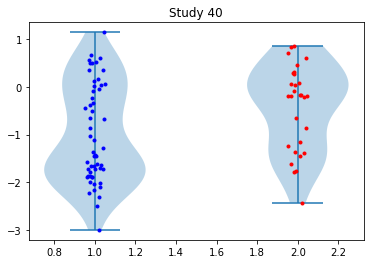

In [25]:
mw=test_res(40,'../dysbiosis_index/40_dysbiosis_index.txt')

exp ../studies/16/ - AmpliconExperiment with 119 samples, 2116 features
Healthy median -1.704015(mean -2.153148). sick median -2.265894 (mean -2.550233)
MannwhitneyuResult(statistic=1939.5, pvalue=0.9786155132856728)


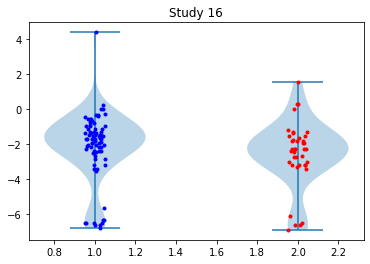

In [27]:
mw=test_res(16,'../dysbiosis_index/binary/16.txt',)

exp ../studies/40/ - AmpliconExperiment with 85 samples, 3917 features
Healthy median -2.157563(mean -2.149054). sick median -2.032722 (mean -2.006812)
MannwhitneyuResult(statistic=624.0, pvalue=0.04110544746886762)


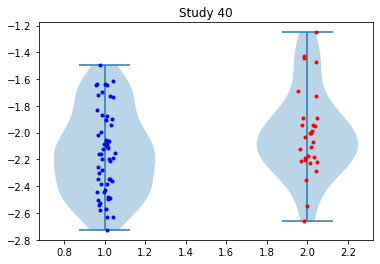

In [33]:
mw=test_res(40,'../dysbiosis_index/samplerank/40.txt',)

In [34]:
studies=pd.read_csv('../studies/index.csv',sep='\t')

In [36]:
db_binary={}
db_gevers={}
db_freqs={}
db_ranks={}
db_samplerank={}
for cs in studies.iterrows():
    cs = cs[1]
    print('%s (%s)' % (cs['disease'], cs['sampleid']))
    print('tzipi')
    csid = cs['sampleid']
    mw=test_res(csid,'../dysbiosis_index/%s_dysbiosis_index.txt' % csid,plotit=False)
    db_gevers[csid]=mw
    print('binary')
    mw=test_res(csid,'../dysbiosis_index/binary/%s.txt' % csid,plotit=False)
    db_binary[csid]=mw
    print('freq')
    mw=test_res(csid,'../dysbiosis_index/freqs/%s.txt' % csid,plotit=False)
    db_freqs[csid]=mw
    print('rank')
    mw=test_res(csid,'../dysbiosis_index/ranks/%s.txt' % csid,plotit=False)
    db_ranks[csid]=mw
    mw=test_res(csid,'../dysbiosis_index/samplerank/%s.txt' % csid,plotit=False)
    db_samplerank[csid]=mw


Alzheimer (17)
tzipi
exp ../studies/17/ - AmpliconExperiment with 50 samples, 2307 features
Healthy median -1.858416(mean -1.864470). sick median -1.697781 (mean -1.772650)
MannwhitneyuResult(statistic=255.0, pvalue=0.1343713862105385)
binary
exp ../studies/17/ - AmpliconExperiment with 50 samples, 2307 features
Healthy median -2.411694(mean -2.404409). sick median -0.995513 (mean -1.244474)
MannwhitneyuResult(statistic=140.0, pvalue=0.0004225101832644758)
freq
exp ../studies/17/ - AmpliconExperiment with 50 samples, 2307 features
Healthy median -6.302661(mean -5.858335). sick median -4.574364 (mean -4.138208)
MannwhitneyuResult(statistic=195.0, pvalue=0.011599743657534665)
rank
exp ../studies/17/ - AmpliconExperiment with 50 samples, 2307 features
Healthy median -2.081480(mean -2.126307). sick median -1.510170 (mean -1.623397)
MannwhitneyuResult(statistic=147.0, pvalue=0.0006836409650876575)
exp ../studies/17/ - AmpliconExperiment with 50 samples, 2307 features
Healthy median -2.07076

exp ../studies/40/ - AmpliconExperiment with 85 samples, 3917 features
Healthy median -2.157563(mean -2.149054). sick median -2.032722 (mean -2.006812)
MannwhitneyuResult(statistic=624.0, pvalue=0.04110544746886762)
Cancer (46)
tzipi
exp ../studies/46/ - AmpliconExperiment with 554 samples, 10980 features
Healthy median -0.698537(mean -0.713330). sick median -0.562967 (mean -0.607844)
MannwhitneyuResult(statistic=32735.0, pvalue=0.11499620108208741)
binary
exp ../studies/46/ - AmpliconExperiment with 554 samples, 10980 features
Healthy median -3.207158(mean -3.257333). sick median -3.296241 (mean -3.303993)
MannwhitneyuResult(statistic=35681.5, pvalue=0.612920830635446)
freq
exp ../studies/46/ - AmpliconExperiment with 554 samples, 10980 features
Healthy median -6.420527(mean -6.222034). sick median -6.343782 (mean -6.156718)
MannwhitneyuResult(statistic=35163.0, pvalue=0.4997787990282502)
rank
exp ../studies/46/ - AmpliconExperiment with 554 samples, 10980 features
Healthy median -1.6

binary
exp ../studies/6/ - AmpliconExperiment with 612 samples, 4175 features
Healthy median -3.232039(mean -3.435047). sick median -2.907334 (mean -3.175115)
MannwhitneyuResult(statistic=42359.0, pvalue=0.03710112097745132)
freq
exp ../studies/6/ - AmpliconExperiment with 612 samples, 4175 features
Healthy median -7.037183(mean -7.019689). sick median -6.460216 (mean -6.684127)
MannwhitneyuResult(statistic=42025.0, pvalue=0.026249384907159896)
rank
exp ../studies/6/ - AmpliconExperiment with 612 samples, 4175 features
Healthy median -1.829778(mean -1.732925). sick median -1.722446 (mean -1.656461)
MannwhitneyuResult(statistic=40968.0, pvalue=0.007647256477284496)
exp ../studies/6/ - AmpliconExperiment with 612 samples, 4175 features
Healthy median -2.018108(mean -1.938324). sick median -1.939413 (mean -1.883312)
MannwhitneyuResult(statistic=41255.0, pvalue=0.010915794262785092)
Diabetes T2 (33)
tzipi
exp ../studies/33/ - AmpliconExperiment with 58 samples, 1250 features
Healthy median

exp ../studies/19/ - AmpliconExperiment with 68 samples, 1401 features
Healthy median -2.070591(mean -2.059502). sick median -2.037276 (mean -2.001869)
MannwhitneyuResult(statistic=459.0, pvalue=0.07381387257934703)
HIV (16)
tzipi
exp ../studies/16/ - AmpliconExperiment with 119 samples, 2116 features
Healthy median -0.941121(mean -0.981485). sick median -0.997859 (mean -1.021529)
MannwhitneyuResult(statistic=1672.0, pvalue=0.6985912727377062)
binary
exp ../studies/16/ - AmpliconExperiment with 119 samples, 2116 features
Healthy median -1.704015(mean -2.153148). sick median -2.265894 (mean -2.550233)
MannwhitneyuResult(statistic=1939.5, pvalue=0.9786155132856728)
freq
exp ../studies/16/ - AmpliconExperiment with 119 samples, 2116 features
Healthy median -6.029417(mean -5.890072). sick median -6.987342 (mean -6.970403)
MannwhitneyuResult(statistic=1837.0, pvalue=0.9262684474113729)
rank
exp ../studies/16/ - AmpliconExperiment with 119 samples, 2116 features
Healthy median -0.717712(mean

Healthy median -4.444067(mean -4.123985). sick median -1.561334 (mean -0.003738)
MannwhitneyuResult(statistic=1387.0, pvalue=2.244808141995335e-05)
rank
exp ../studies/21/ - AmpliconExperiment with 178 samples, 2597 features
Healthy median -1.790762(mean -1.805300). sick median -1.485537 (mean -1.518018)
MannwhitneyuResult(statistic=1492.0, pvalue=0.00010932276017865828)
exp ../studies/21/ - AmpliconExperiment with 178 samples, 2597 features
Healthy median -1.506726(mean -1.551653). sick median -1.288634 (mean -1.322954)
MannwhitneyuResult(statistic=1430.0, pvalue=4.3663401239771794e-05)
IBD_Crohn disease (29)
tzipi
exp ../studies/29/ - AmpliconExperiment with 594 samples, 3470 features
Healthy median -1.251807(mean -1.134026). sick median -0.717286 (mean -0.614512)
MannwhitneyuResult(statistic=18302.0, pvalue=7.666375969537975e-09)
binary
exp ../studies/29/ - AmpliconExperiment with 594 samples, 3470 features
Healthy median -1.390192(mean -1.304515). sick median -1.042547 (mean -0.873

exp ../studies/42/ - AmpliconExperiment with 96 samples, 3829 features
Healthy median -1.999531(mean -1.964847). sick median -1.789183 (mean -1.817295)
MannwhitneyuResult(statistic=736.0, pvalue=0.0037652109094153292)
IBD_Ulcerative Colitis (22)
tzipi
exp ../studies/22/ - AmpliconExperiment with 144 samples, 2687 features
Healthy median -1.854790(mean -1.966523). sick median -1.831827 (mean -1.999512)
MannwhitneyuResult(statistic=1933.0, pvalue=0.5481928216265062)
binary
exp ../studies/22/ - AmpliconExperiment with 144 samples, 2687 features
Healthy median -1.816609(mean -1.313479). sick median -0.437877 (mean -0.427692)
MannwhitneyuResult(statistic=1084.0, pvalue=6.31784163851815e-05)
freq
exp ../studies/22/ - AmpliconExperiment with 144 samples, 2687 features
Healthy median -4.782402(mean -4.214646). sick median -3.068048 (mean -2.418072)
MannwhitneyuResult(statistic=1169.0, pvalue=0.0002937870382743716)
rank
exp ../studies/22/ - AmpliconExperiment with 144 samples, 2687 features
Hea

exp ../studies/44/ - AmpliconExperiment with 835 samples, 11915 features
Healthy median -0.639219(mean -0.723272). sick median -0.841713 (mean -0.730597)
MannwhitneyuResult(statistic=87822.0, pvalue=0.6369282628829478)
binary
exp ../studies/44/ - AmpliconExperiment with 835 samples, 11915 features
Healthy median -3.360124(mean -3.313860). sick median -2.817497 (mean -3.013600)
MannwhitneyuResult(statistic=74868.5, pvalue=0.00029271992360935007)
freq
exp ../studies/44/ - AmpliconExperiment with 835 samples, 11915 features
Healthy median -6.297010(mean -6.179461). sick median -5.964124 (mean -6.041930)
MannwhitneyuResult(statistic=82031.0, pvalue=0.08394601978583238)
rank
exp ../studies/44/ - AmpliconExperiment with 835 samples, 11915 features
Healthy median -1.719151(mean -1.680424). sick median -1.613811 (mean -1.597484)
MannwhitneyuResult(statistic=74764.0, pvalue=0.0002618868539978381)
exp ../studies/44/ - AmpliconExperiment with 835 samples, 11915 features
Healthy median -1.915297(m

exp ../studies/5/ - AmpliconExperiment with 333 samples, 4664 features
Healthy median -1.611562(mean -1.673608). sick median -1.539492 (mean -1.564915)
MannwhitneyuResult(statistic=10457.0, pvalue=0.0374104195448373)
exp ../studies/5/ - AmpliconExperiment with 333 samples, 4664 features
Healthy median -1.317102(mean -1.375055). sick median -1.284523 (mean -1.316969)
MannwhitneyuResult(statistic=10890.0, pvalue=0.10569846556732865)
Psoriasis (57)
tzipi
exp ../studies/57/ - AmpliconExperiment with 85 samples, 4058 features
Healthy median -1.754659(mean -1.675278). sick median -1.688017 (mean -1.651029)
MannwhitneyuResult(statistic=868.0, pvalue=0.3808494581722249)
binary
exp ../studies/57/ - AmpliconExperiment with 85 samples, 4058 features
Healthy median -3.174433(mean -3.018414). sick median -3.324754 (mean -3.222956)
MannwhitneyuResult(statistic=966.5, pvalue=0.7131364827285392)
freq
exp ../studies/57/ - AmpliconExperiment with 85 samples, 4058 features
Healthy median -7.605157(mean -

In [37]:
studies['disease'].values

array(['Alzheimer', 'Anorexia', 'Autism', 'Autism', 'Autoimmun diseases',
       'Bipolar', 'Bipolar', 'C.difficile infection', 'Cancer', 'Cancer',
       'Chronic fatigue syndrome', 'Depression', 'Depression',
       'Diabetes T1', 'Diabetes T2', 'Diabetes T2', 'Diabetes T2',
       'Diabetes T2', 'Gastroenteritis', 'Gastroenteritis', 'Gout',
       'Heart diseases', 'Heart diseases', 'Hepatitis B', 'HIV', 'HIV',
       'HIV', 'HIV', 'Hypertension', 'IBD_Crohn disease',
       'IBD_Crohn disease', 'IBD_Crohn disease', 'IBD_Crohn disease',
       'IBD_Crohn disease', 'IBD_Crohn disease', 'IBD_Crohn disease',
       'IBD_Inflammtory bowel disease', 'IBD_Inflammtory bowel disease',
       'IBD_Ulcerative Colitis', 'IBD_Ulcerative Colitis',
       'IBD_Ulcerative Colitis', 'IBD_Ulcerative Colitis',
       'IBD_Ulcerative Colitis', 'Irritable bowel syndrom',
       'Irritable bowel syndrom', 'Irritable bowel syndrom', 'Lupus',
       'Obesity', 'Obesity', 'Obesity', 'Obesity', 'Pancreatiti

In [38]:
    disease_colors = {xx:(0,0,0) for xx in studies.disease.values}
    disease_colors.update({'HIV': (1.00,0.93,0.35),'Autism': (0.50,0.99,0.52),'Bipolar': (1.00, 0.63, 0.00),
         'IBD_Crohn disease': (0.72,0.11,0.11),'IBD_Ulcerative Colitis': (0.72,0.11,0.11),
         'IBD_Inflammtory bowel disease': (0.72,0.11,0.11),
         'Diabetes T2': (0.47,0.53,0.80),
         'Depression': (0.48,0.12,0.64),
         'Obesity': (0.25,0.32,0.71),
         'Parkinson': (0.29,0.08,0.55),
         'Schizophrenia': (0.88,0.75,0.91),     
         'Gastroenteritis': (0.94,0.33,0.31),
         'Heart diseases': (0.33,0.43,1.00),
         'Irritable bowel syndrom': (0.90,0.45,0.45),
         'Alzheimer': (0.83, 0.83, 0.83), 'Anorexia': (0.83, 0.83, 0.83), 'Cancer': (0.83, 0.83, 0.83), 'Autoimmun diseases': (0.83, 0.83, 0.83), 'C.difficile infection': (0.83, 0.83, 0.83), 
         'Cancer': (0.83, 0.83, 0.83), 'Chronic fatigue syndrome': (0.83, 0.83, 0.83), 'Diabetes T1': (0.83, 0.83, 0.83),  'Gout': (0.83, 0.83, 0.83),
         'Hepatitis B': (0.83, 0.83, 0.83), 'Hepatitis C': (0.83, 0.83, 0.83), 'Hypertension': (0.83, 0.83, 0.83), 
         'Lupus': (0.83, 0.83, 0.83), 'Pancreatitis': (0.83, 0.83, 0.83), 'Psoriasis': (0.83, 0.83, 0.83), 'Rheumatoid arthritis': (0.83, 0.83, 0.83), 
                
         })


In [39]:
def compare_pvals2(db1,db2,name1,name2, minval=1E-5, show_text=True):
    f=plt.figure()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([minval*0.9,1])
    plt.xlim([minval*0.9,1])
    plt.plot([minval*0.9,1],[minval*0.9,1],'k')
    plt.plot([minval*0.9,1],[0.05,0.05],':k')
    plt.plot([0.05,0.05],[minval,1],':k')
    for idx,cid in enumerate(db_binary.keys()):
        cx = np.max([db1[cid],minval])
        cy = np.max([db2[cid],minval])
        cdisease=studies[studies.sampleid==cid]['disease'].values[0]
        cstudy=studies[studies.sampleid==cid]['study'].values[0]
        plt.plot(cx, cy,'.',markersize=30, color=disease_colors[cdisease],label=cdisease)
        if show_text:
            plt.text(cx, cy*0.8,cdisease+'_'+cstudy)
    f.set_size_inches(10,10)
    plt.xlabel(name1)
    plt.ylabel(name2)
#     plt.legend()
    return f

In [49]:
def compare_pvals(db1,db2,name1,name2, minval=1E-5, show_text=True, show_num=False):
    f=plt.figure()
#     plt.yscale('log')
#     plt.xscale('log')
    plt.xlim([-np.log10(1),-np.log10(minval*0.9)])
    plt.ylim([-np.log10(1),-np.log10(minval*0.9)])
    ticks=np.arange(-np.log10(1),-np.log10(minval*0.9))
    plt.xticks(ticks, 10**(-ticks))
    plt.yticks(ticks, 10**(-ticks))
    plt.plot([-np.log10(minval*0.9),-np.log10(1)],[-np.log10(minval*0.9),-np.log10(1)],'k')
    plt.plot([-np.log10(minval*0.9),-np.log10(1)],[-np.log10(0.05),-np.log10(0.05)],':k')
    plt.plot([-np.log10(0.05),-np.log10(0.05)],[-np.log10(minval),-np.log10(1)],':k')
    # draw the rectangles
    rect = mpl.patches.Rectangle((0,0),-np.log10(0.05),-np.log10(0.05),linewidth=1,edgecolor='w',facecolor=(1,0.85,0.85))
    plt.gca().add_patch(rect)
    rect = mpl.patches.Rectangle((0,-np.log10(0.05)),-np.log10(0.05),-np.log10(minval),linewidth=1,edgecolor='w',facecolor=(0.85,1,0.85))
    plt.gca().add_patch(rect)
    rect = mpl.patches.Rectangle((-np.log10(0.05),0),-np.log10(minval),-np.log10(0.05),linewidth=1,edgecolor='w',facecolor=(0.9,0.9,1))
    plt.gca().add_patch(rect)

    
    for idx,cid in enumerate(db_binary.keys()):
        cx = np.max([db1[cid],minval])
        cy = np.max([db2[cid],minval])
        cdisease=studies[studies.sampleid==cid]['disease'].values[0]
        cstudy=studies[studies.sampleid==cid]['study'].values[0]
        plt.plot(-np.log10(cx), -np.log10(cy),'.',markersize=30, color=disease_colors[cdisease],label=cdisease)
        if cx<=minval and cy<=minval:
            print('*** study %s cx %f cy %f' % (cdisease+'_'+cstudy, cx, cy))
            pass
        if show_text:
            plt.text(-np.log10(cx), -np.log10(cy*0.8),cdisease+'_'+cstudy)
        if show_num:
            cidnum = studies[studies['sampleid']==cid]['dys_number'].values[0]
            plt.text(-np.log10(cx), -np.log10(cy)-0.01,str(cidnum), horizontalalignment='center',verticalalignment='center',fontdict={'weight': 'bold', 'color':'black'})
            plt.text(-np.log10(cx), -np.log10(cy)+0.01,str(cidnum), horizontalalignment='center',verticalalignment='center',fontdict={'weight': 'bold', 'color':'black'})
            plt.text(-np.log10(cx)-0.01, -np.log10(cy),str(cidnum), horizontalalignment='center',verticalalignment='center',fontdict={'weight': 'bold', 'color':'black'})
            plt.text(-np.log10(cx)+0.01, -np.log10(cy),str(cidnum), horizontalalignment='center',verticalalignment='center',fontdict={'weight': 'bold', 'color':'black'})
            plt.text(-np.log10(cx), -np.log10(cy),str(cidnum), horizontalalignment='center',verticalalignment='center',fontdict={'weight': 'bold', 'color':'white'})
            print('ID %d - %s %s' % (cidnum, cdisease, cstudy))
    f.set_size_inches(10,10)
    plt.xlabel(name1)
    plt.ylabel(name2)
#     plt.legend()
    return f

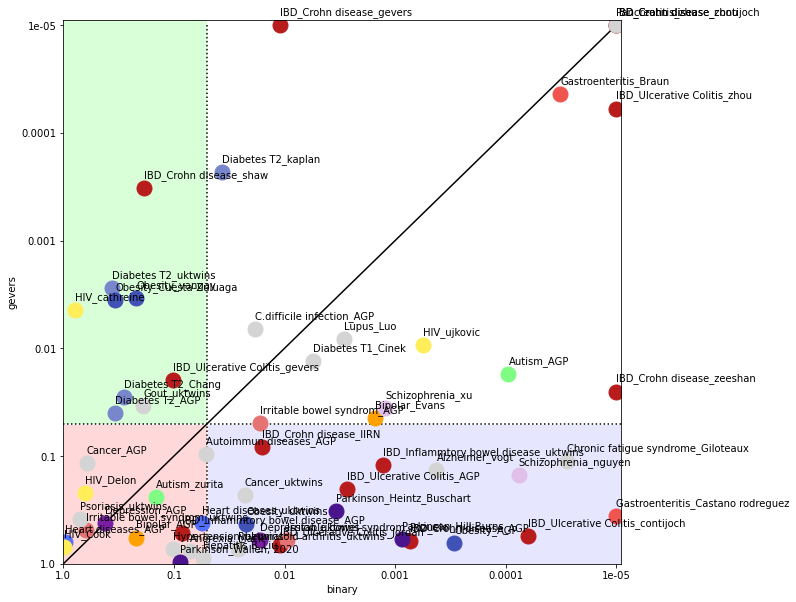

In [41]:
f=compare_pvals(db_binary,db_gevers,'binary','gevers')

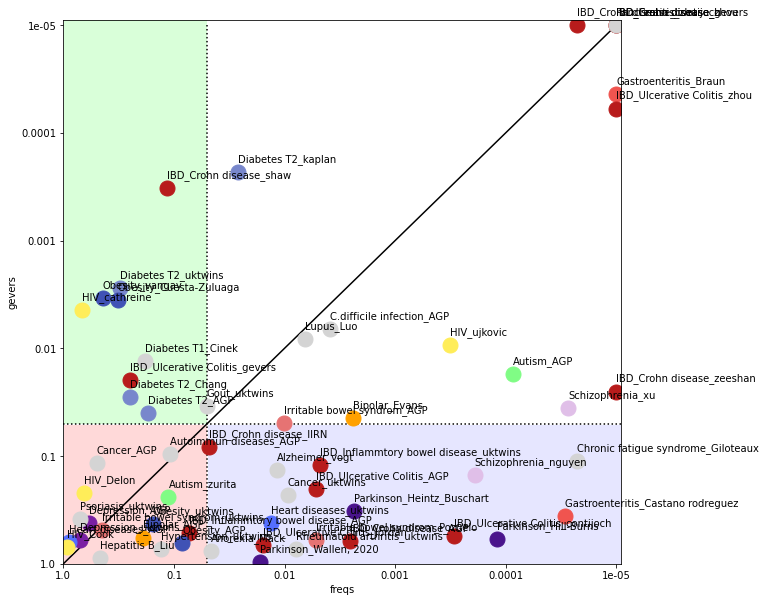

In [42]:
f=compare_pvals(db_freqs,db_gevers,'freqs','gevers')

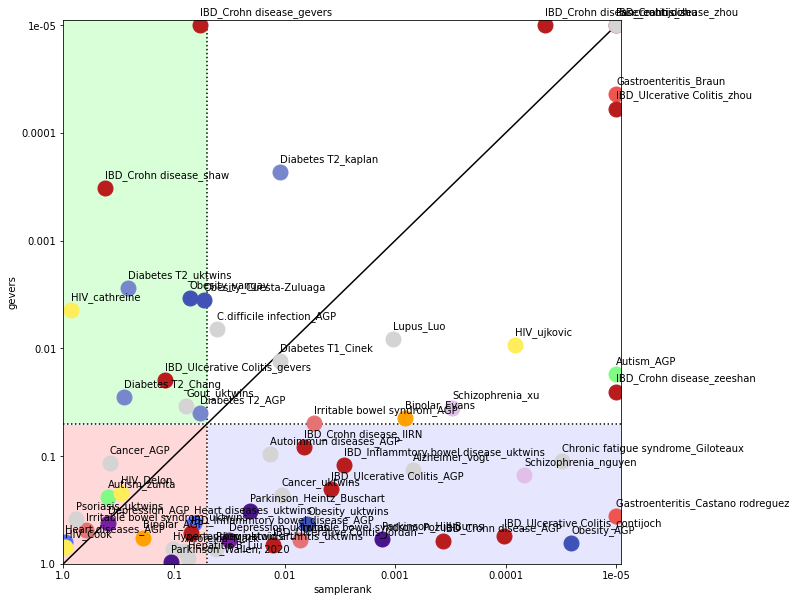

In [43]:
f=compare_pvals(db_samplerank,db_gevers,'samplerank','gevers')

ID 1 - Alzheimer vogt
ID 2 - Anorexia Mack
ID 3 - Autism AGP
ID 4 - Autism zurita
ID 5 - Autoimmun diseases AGP
ID 6 - Bipolar AGP
ID 7 - Bipolar Evans
ID 8 - C.difficile infection AGP
ID 9 - Cancer AGP
ID 10 - Cancer uktwins
ID 11 - Chronic fatigue syndrome Giloteaux
ID 12 - Depression AGP
ID 13 - Depression uktwins
ID 14 - Diabetes T1 Cinek
ID 15 - Diabetes T2 AGP
ID 16 - Diabetes T2 kaplan
ID 17 - Diabetes T2 Chang
ID 18 - Diabetes T2 uktwins
ID 19 - Gastroenteritis Braun
ID 20 - Gastroenteritis Castano rodreguez
ID 21 - Gout uktwins
ID 22 - Heart diseases AGP
ID 23 - Heart diseases uktwins
ID 24 - Hepatitis B Liu
ID 25 - HIV Cook
ID 26 - HIV Delon
ID 27 - HIV cathreine
ID 28 - HIV ujkovic
ID 29 - Hypertension uktwins
ID 30 - IBD_Crohn disease AGP
ID 31 - IBD_Crohn disease IIRN
ID 32 - IBD_Crohn disease contijoch
ID 33 - IBD_Crohn disease gevers
ID 34 - IBD_Crohn disease zeeshan
ID 35 - IBD_Crohn disease shaw
*** study IBD_Crohn disease_zhou cx 0.000010 cy 0.000010
ID 36 - IBD_Crohn

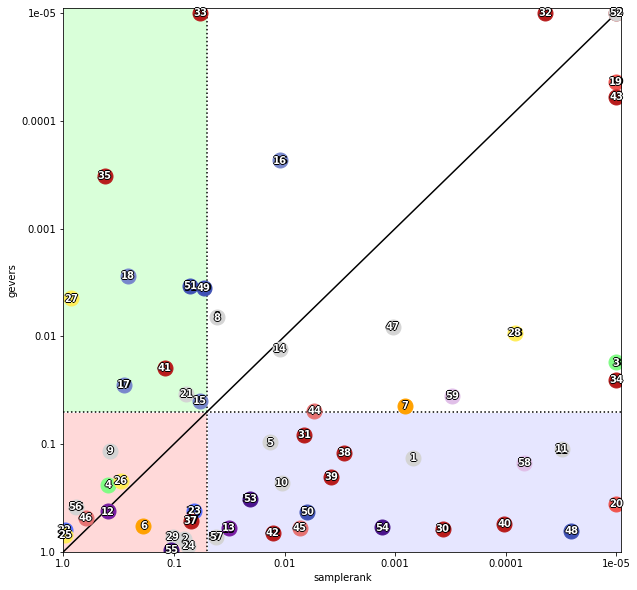

In [50]:
f=compare_pvals(db_samplerank,db_gevers,'samplerank','gevers',show_text=False, show_num=True)
f.savefig('../figures/dysbiosis-with-numbers.pdf')

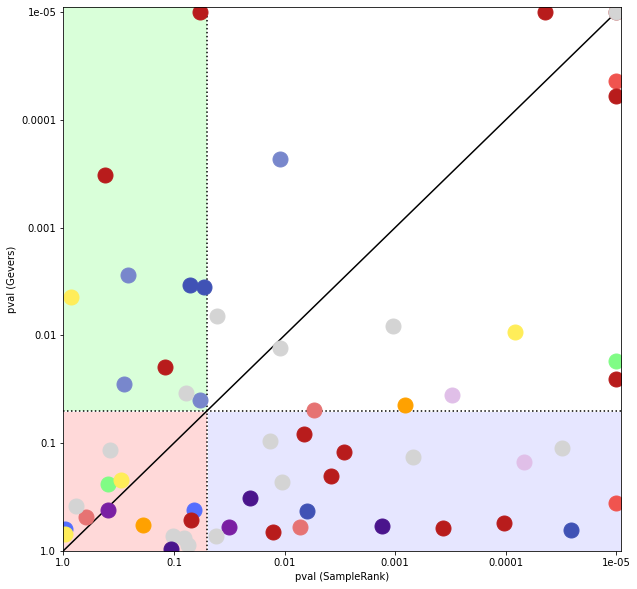

In [45]:
f=compare_pvals(db_samplerank,db_gevers,'pval (SampleRank)','pval (Gevers)',show_text=False)
f.savefig('../figures/dysbiosis-rank-gevers.pdf')

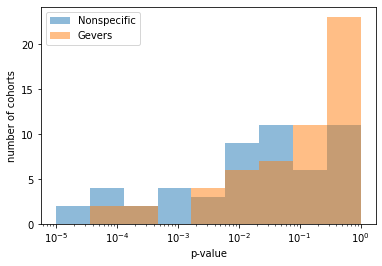

In [46]:
f=plt.figure()
bins=np.logspace(-5,0,10)
plt.hist(db_samplerank.values(),bins,alpha=0.5)
plt.hist(db_gevers.values(),bins,alpha=0.5)
plt.xscale('log')
plt.xlabel('p-value')
plt.ylabel('number of cohorts')
plt.legend(('Nonspecific','Gevers'))
f.savefig('../figures/dysbiosis-index-pvals.pdf')

In [48]:
print(sp.stats.mannwhitneyu(list(db_samplerank.values()),list(db_gevers.values())))
print(np.mean(list(db_samplerank.values())))
print(np.mean(list(db_gevers.values())))
print(np.median(list(db_samplerank.values())))
print(np.median(list(db_gevers.values())))

MannwhitneyuResult(statistic=1208.0, pvalue=0.002095834746246056)
0.13561157881457533
0.264234416229712
0.013553157139419228
0.12062883379905204


exp ../studies/2/ - AmpliconExperiment with 179 samples, 2528 features
Healthy median -1.405389(mean -1.407085). sick median -1.320467 (mean -1.315846)
MannwhitneyuResult(statistic=3114.0, pvalue=0.044381902317601564)


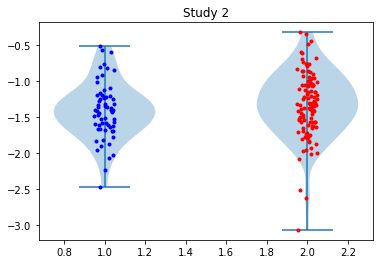

In [57]:
mw=test_res(2,'../dysbiosis/2_dysbiosis_index.txt',)

exp ../studies/2/ - AmpliconExperiment with 179 samples, 2528 features
Healthy median -6.506363(mean -5.821232). sick median -4.811126 (mean -4.397246)
MannwhitneyuResult(statistic=2742.0, pvalue=0.0023896582737273075)


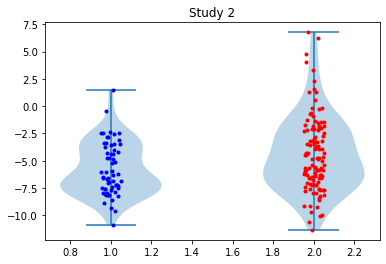

In [58]:
mw=test_res(2,'../dysbiosis/freqs/2.txt',)

exp ../studies/2/ - AmpliconExperiment with 179 samples, 2528 features
Healthy median -1.849243(mean -1.832228). sick median -1.646094 (mean -1.650676)
MannwhitneyuResult(statistic=2651.0, pvalue=0.0009826677780857267)


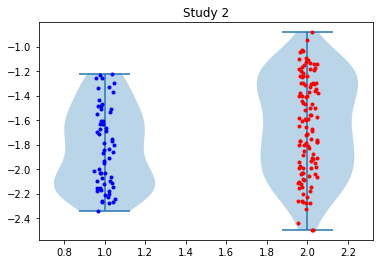

In [59]:
mw=test_res(2,'../dysbiosis/samplerank/2.txt',)

exp ../studies/24/ - AmpliconExperiment with 25 samples, 999 features
Healthy median -1.637563(mean -1.656878). sick median -1.588048 (mean -1.598233)
MannwhitneyuResult(statistic=71.0, pvalue=0.42303114661179897)


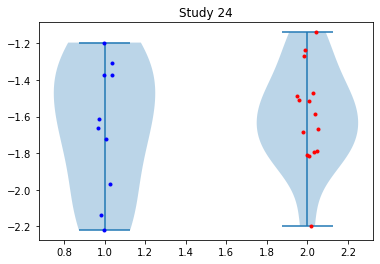

In [382]:
mw=test_res(24,'../dysbiosis/ranks/24.txt',)

exp ../studies/24/ - AmpliconExperiment with 25 samples, 999 features
Healthy median -1.540081(mean -1.566919). sick median -1.501852 (mean -0.839158)
MannwhitneyuResult(statistic=59.5, pvalue=0.20264511136163454)


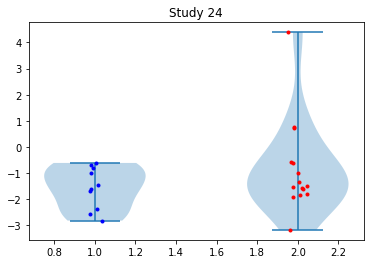

In [373]:
mw=test_res(24,'../dysbiosis/binary/24.txt',)

In [467]:
studies[studies.sampleid==62]

,sampleid,disease,authors,study,Country,sample_source,updated,notes,2,3,4,5
58,62,Hypertension,uktwins,uktwins,UK,stool,V,females,adults,NaN,NaN,NaN


In [413]:
aa = ca.read_amplicon('../studies/24/all.biom','../studies/24/up.map.csv',min_reads=1000,normalize=10000, sparse=False)

In [419]:
aaa=aa.filter_ids(ns._feature_id.values)

In [447]:
aa1=aaa.filter_samples('type','HC')
aa2=aaa.filter_samples('type','disease')

In [452]:
mean1=np.mean(aa1.data,axis=0)
mean2=np.mean(aa2.data,axis=0)
std1=np.std(aa1.data,axis=0)
std2=np.std(aa2.data,axis=0)
mdiff = mean2 - mean1
mz = 2 * mdiff / (std1+std2)
aaa.feature_metadata['zscore'] = mz
aaa.feature_metadata['mean'] = mdiff
aaa.feature_metadata['std'] = (std1+std2)/2

In [453]:
cu.splot(aaa,'type')

In [422]:
aaa.feature_metadata=aaa.feature_metadata.join(ns.set_index('_feature_id'),lsuffix='l',on='_feature_id',how='inner')

In [423]:
cu.splot(aaa,'type')

In [404]:
ns

,_feature_id,common_term,taxonomy,dir
0,TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGG...,feces,d__Bacteria;p__Firmicutes;c__Erysipelotrichia;...,down
1,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,feces,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,down
2,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,feces,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,down
3,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,feces,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,down
4,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,feces,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,down
...,...,...,...,...
119,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,feces,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,up
120,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCA...,feces,"d__Bacteria;p__""Proteobacteria"";c__Gammaproteo...",up
121,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,feces,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,up
122,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,feces,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,up


In [424]:
dd=aa.diff_abundance('type','HC')

In [425]:
dd

AmpliconExperiment with 25 samples, 14 features

In [518]:
cu.splot(dd,'type')

In [427]:
ss='TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACGCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGGTGTCTTGAGTACAGTAGAGGCAGGCGGAATTCGTGG'
len(ss)

150

In [ ]:
aa.diff_abundance()